In [1]:
import numpy as np
from math import gamma
import scipy.optimize as opt
import scipy.stats as sts
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.linalg import pinv

## Problem 3.
## a)

In [2]:
incomes = np.loadtxt(r'C:\Users\Max\Documents\BootCamp2017\Econ\Wk4_StrEst\data\usincmoms.txt')
pct, mps = incomes.T
mps_mil = np.copy(mps) / 1000

In [3]:
def plot_bars(mps, pct, add_lines=None, labels=None):
    xvals = np.copy(mps)
    
    yvals = np.copy(pct)
    yvals[-2] = yvals[-2] / 10
    yvals[-1] = yvals[-1] / 20
    bin_width = [(x+2.5)-(x-2.5) for x in xvals]
    bin_width[-2] = 50.0
    bin_width[-1] = 100.0
    
    plt.bar(xvals, height=yvals, width=bin_width, edgecolor='black')
    
    if add_lines is None:
        plt.bar(xvals, height=yvals, width=bin_width, edgecolor='red', alpha=0.3)
        plt.show()
    else:
        plt.bar(xvals, height=yvals, width=bin_width, edgecolor='red', alpha=0.4)
        for i in range(len(add_lines)):
            line = add_lines[i]
            plt.plot(line[0], line[1], label=labels[i])
        plt.legend()
        plt.show()

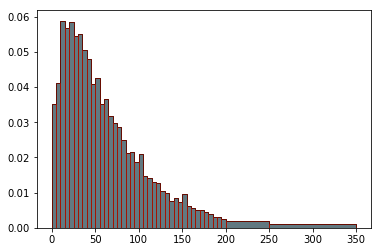

In [4]:
plot_bars(mps_mil, pct)

## b) GMM fitting the log norm distribution

In [5]:
def log_norm_cdf(x, mu, sigma):
    
    cdf_vals = sts.lognorm.cdf(x, s=sigma, scale=mu)
    
    return cdf_vals

def model_moms_ln(x, mu, sigma):
    
    moms_model = np.zeros(42)
    moms_model[1:40] = (log_norm_cdf((x[1:40] + 2.5), mu, sigma) -
                         log_norm_cdf((x[1:40] - 2.5), mu, sigma))
    moms_model[0] = log_norm_cdf(5, mu, sigma)
    
    moms_model[40] = (log_norm_cdf(250, mu, sigma) -
                      log_norm_cdf(200, mu, sigma))
    
    moms_model[41] = (log_norm_cdf(np.inf, mu, sigma) -
                      log_norm_cdf(250, mu, sigma))
    
    return moms_model

def err_vec_ln(x, moms_data, mu, sigma, simple):
    
    moms_model = model_moms_ln(x, mu, sigma)
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec

def crit_ln(params, *args):
    mu, sigma = params
    x, moms_data, W = args
    
    err = err_vec_ln(x, moms_data, mu, sigma, simple=True)
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val

In [6]:
W_init = np.diag(pct)
mu_0 = np.log(np.mean(mps_mil))
params_init = np.array([5, 1])
a = crit_ln(params_init, mps_mil, pct, W_init)

In [7]:
res_ln = opt.minimize(crit_ln, params_init, args=(mps_mil, pct, W_init),
                     method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_ln, sigma_ln = res_ln.x
crit_fun_ln = res_ln.fun
print('Estimation results for alpha:', mu_ln, 'and for beta:', sigma_ln)
print('Criterion Value:', crit_fun_ln)

res_ln

Estimation results for alpha: 49.8850749117 and for beta: 0.952289669837
Criterion Value: 5.42268758675e-05


      fun: 5.4226875867457987e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  8.20205720e-08,  -4.54951493e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 57
      nit: 16
   status: 0
  success: True
        x: array([ 49.88507491,   0.95228967])

In [9]:
ln_fit = model_moms_ln(mps_mil, mu_ln, sigma_ln)
ln_fit[-2] = ln_fit[-2] / 10
ln_fit[-1] = ln_fit[-1] / 20
lines_ln = np.concatenate([mps_mil, ln_fit]).reshape(2, 42)
ln_label = ['fitted log norm']

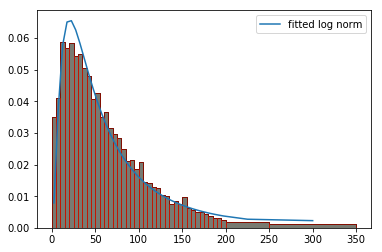

In [10]:
plot_bars(mps_mil, pct, add_lines=[lines_ln], labels=ln_label)

## c)

In [12]:
def gamma_pdf_own(xvals, alpha, beta):
    
    numerator = xvals **(alpha - 1) * np.exp(-(xvals / beta))
    #print(alpha)
    denominator =   (beta ** alpha)*gamma(alpha) 
    pdf_vals =  numerator / denominator
    
    return pdf_vals

In [13]:
def gamma_cdf(xvals, alpha, beta):
    
    cdf_vals = sts.gamma.cdf(xvals, a=alpha, scale = beta)
    return cdf_vals

def model_moms_gam(x, alpha, beta):
    
    moms_model = np.zeros(42)
    moms_model[1:40] = (gamma_cdf((x[1:40] + 2.5), alpha, beta) -
                         gamma_cdf((x[1:40] - 2.5), alpha, beta))
    moms_model[0] = gamma_cdf(5, alpha, beta)
    
    moms_model[40] = (gamma_cdf(250, alpha, beta) -
                      gamma_cdf(200, alpha, beta))
    
    moms_model[41] = (gamma_cdf(np.inf, alpha, beta) -
                      gamma_cdf(250, alpha, beta))
    
    return moms_model

def err_vec_gam(x, moms_data, alpha, beta, simple):
    
    moms_model = model_moms_gam(x, alpha, beta)
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec

def crit_gam(params, *args):
    alpha, beta = params
    x, moms_data, W = args
    
    err = err_vec_gam(x, moms_data, alpha, beta, simple=True)
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val

In [14]:
alpha_0 = 3
beta_0 = 20000
gamma_cdf(mps_mil, alpha_0, beta_0/1000)
model_moms_gam(mps_mil, alpha_0, beta_0/1000)
params_init_gam = np.array([alpha_0, beta_0/1000])

In [15]:
res_gam = opt.minimize(crit_gam, params_init_gam, args=(mps_mil, pct, W_init), 
                      method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

alpha_gam, beta_gam = res_gam.x
crit_fun_gam = res_gam.fun

print('Estimation results for alpha:', alpha_gam, 'and for beta:', beta_gam*1000)
print('Criterion Value:', crit_fun_gam)

res_gam

Estimation results for alpha: 1.50411195985 and for beta: 41181.090293
Criterion Value: 1.43637195722e-05


      fun: 1.4363719572233851e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -8.92854550e-07,  -1.67556432e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 48
      nit: 14
   status: 0
  success: True
        x: array([  1.50411196,  41.18109029])

In [16]:
gam_fit = model_moms_gam(mps_mil, alpha_gam, beta_gam)
gam_fit[-2] = ln_fit[-2]
gam_fit[-1] = ln_fit[-1]
lines_gam = np.concatenate([mps_mil, gam_fit]).reshape(2, 42)
gam_label = ['fitted gamma']

lines_c = [lines_gam, lines_ln]
label_c = ['fitted gamma', 'fitted log normal']

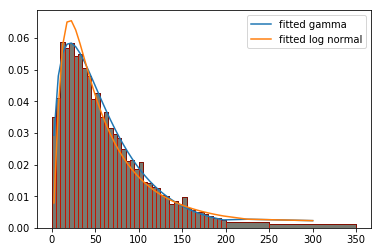

In [17]:
plot_bars(mps_mil, pct, add_lines=lines_c, labels=label_c)

It is quite hard to tell which distrubution fits better.However, gama distribution be a little closer to the empirical momentsmost of the time whereas the log-normal distribution puts too much probability mass on the modal value. The criterion function for the gamma distribution is only little smaller.

## e)
two step estimator for the weighting matrix W. (This implies unlike the earlier problems to start with W_init = identity matric´x, right?)

In [18]:
alpha2_0 = 3
beta2_0 = 20000
W2_init = np.identity(42)
gamma_cdf(mps_mil, alpha2_0, beta2_0/1000)
model_moms_gam(mps_mil, alpha2_0, beta2_0/1000)
params_init_gam = np.array([alpha2_0, beta2_0/1000])

res_gam12 = opt.minimize(crit_gam, params_init_gam, args=(mps_mil, pct, W2_init), 
                      method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

alpha_gam12, beta_gam12 = res_gam12.x
crit_fun12 = res_gam12.fun

print('Estimation results for alpha:', alpha_gam12, 'and for beta:', beta_gam12*1000)
print('Criterion Value:', crit_fun12)

Estimation results for alpha: 1.37243071957 and for beta: 48327.5841634
Criterion Value: 0.000311781168919


The parameters change a little in the first stage and the criterion is a little larger compared to using the population size weights like inthe earlier problems.

In [39]:
err_gam12_fin = err_vec_gam(mps_mil, pct, alpha_gam12, beta_gam12, simple=True)
err_gam12_fin = err_gam12_fin.reshape(1, 42)
VCV_gam2 = np.dot(err_gam12_fin.T, err_gam12_fin) / len(pct)
W_step2 = pinv(VCV_gam2)

In [42]:
res_gam22 = opt.minimize(crit_gam, params_init_gam, args=(mps_mil, pct, W_step2), 
                      method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

alpha_gam22, beta_gam22 = res_gam22.x
crit_fun22 = res_gam22.fun
print('Estimation results for alpha:', alpha_gam22, 'and for beta:',
      beta_gam22*1000)
print('Criterion Value:', crit_fun22)

res_gam22

Estimation results for alpha: 580.986561376 and for beta: 0.0212177567932
Criterion Value: -8.89065965075e+19


      fun: -8.8906596507477426e+19
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.63840000e+12,  -3.64380160e+15])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 378
      nit: 74
   status: 0
  success: True
        x: array([  5.80986561e+02,   2.12177568e-02])

These look really wierd...